In [26]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import loads
from sklearn.cluster import KMeans
import numpy as np

In [27]:
gdf = gpd.read_file("../data/SANGIS/BUSINESS_SITES/BUSINESS_SITES.shp")
gdf = gdf.to_crs(crs='EPSG:4326')
gdf = gdf[gdf['POINT_X']!=0]
gdf['x'] = gdf['geometry'].x
gdf['y'] = gdf['geometry'].y

In [28]:
gdf

,APN,BCCCODE,OWNNAM1,OWNNAM2,OWNNAM3,CAREOF,STRNUM,STRFRA,STRDIR,STRNAM,...,LOCTYP,LOCSRM,LOCCIT,BUSTYPE,SITE_ADDRE,POINT_X,POINT_Y,geometry,x,y
0,1.010101e+09,131.0,PACIFIC MARINE CREDIT UNION,None,None,ATTN ACCOUNTING DEPT,1278.0,None,None,ROCKY POINT,...,RD,000501,CAMP PENDLETON,CREDIT UNION EXEMPT,525111 BASILONE RD,6.180956e+06,2.128315e+06,POINT (-117.49889 33.50132),-117.498891,33.501317
1,1.010101e+09,291.0,HRB TAX GROUP INC,H&R BLOCK #6438,None,ATTN BUSINESS PP TAX #6438,1.0,None,None,H&R BLOCK,...,None,None,OCEANSIDE,ACCOUNTANT,0 CAMP PENDLETON,6.180956e+06,2.128315e+06,POINT (-117.49889 33.50132),-117.498891,33.501317
2,1.010101e+09,314.0,NORTH COUNTY PIZZA INC,DBA DOMINOS PIZZA #8357,None,None,0.0,None,None,PO BOX 4489,...,RD,None,CAMP PENDLETON,CAFE-FAST FOOD,520407 BASILONE RD,6.180956e+06,2.128315e+06,POINT (-117.49889 33.50132),-117.498891,33.501317
3,1.010101e+09,314.0,PIAZZA MANAGEMENT CORPORATION,OF SAN DIEGO,PIAZZA FAMILY RESTAURANTS INC,DBA MCDONALDS #34729,23113.0,None,None,PLAZA POINTE,...,ST,None,CAMP PENDLETON,CAFE-FAST FOOD,430314 BROWN ST,6.180956e+06,2.128315e+06,POINT (-117.49889 33.50132),-117.498891,33.501317
4,1.010101e+09,404.0,BRIDGESTONE RETAIL,OPERATIONS LLC,DBA FIRESTONE COMPLT AUTO CARE,ATTN TAX DEPT,200.0,None,S,4TH,...,RD,None,CAMP PENDLETON,TIRES&GENERAL MERCH,51091 BASILONE RD,6.180956e+06,2.128315e+06,POINT (-117.49889 33.50132),-117.498891,33.501317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98158,0.000000e+00,261.0,XTRA INC,OFFICE EQUIP&FURN SEE APT HSE,#472-440-02-00,None,0.0,None,None,None,...,AVE,None,SAN DIEGO,APARTMENTS,5802 UNIVERSITY AVE,6.308874e+06,1.853500e+06,POINT (-117.07218 32.74956),-117.072181,32.749555
98159,0.000000e+00,264.0,HONEYCOMB BUSINESS,(A CALIF CORP),DBA LA PETITE ROUGE,None,6840.0,None,None,EL CAJON,...,BLVD,None,SAN DIEGO,MOTEL FURNISHINGS,6844 EL CAJON BLVD,6.315622e+06,1.860472e+06,POINT (-117.05041 32.76886),-117.050408,32.768862
98160,0.000000e+00,298.0,ADVANCED LOGISTICS TECH INC,EQUIPMENT LOCATED AT NAVAL,COMM CONTROL & OCEAN SURV CTR,None,7968.0,None,None,ARJONS,...,BLVD,None,SAN DIEGO,MISC PROFESSIONAL,271 CATALINA BLVD,6.254424e+06,1.839227e+06,POINT (-117.24882 32.70902),-117.248819,32.709024
98161,0.000000e+00,298.0,AT&T,EQUIPMENT LOCATED AT NAVAL,COMM CONTROL & OCEAN SURV CTR,None,3940.0,None,None,7TH,...,BLVD,None,SAN DIEGO,MISC PROFESSIONAL,271 CATALINA BLVD,6.254424e+06,1.839227e+06,POINT (-117.24882 32.70902),-117.248819,32.709024


In [29]:
labels = pd.read_csv('../generate_labels.csv')
final_merge = gdf.merge(labels, how='left', left_on='BUSTYPE',right_on='Items')
final_merge = final_merge[~final_merge['Categories'].isna()]

In [30]:
import geopandas as gpd
import h3pandas as h3pd
import matplotlib.pyplot as plt


Merge the data with the newly generated hexbins

## Use the 70 Largest Hexbins as 'Centers' For Clustering

In [31]:
df2 = final_merge.h3.geo_to_h3(10)
df2['lng']=df2['x']
df2['lat']=df2['y']
df2['Count']=1
df3 = df2[['lng','lat','Count']].reset_index().h3.geo_to_h3_aggregate(10, return_geometry=False).h3.h3_to_parent_aggregate(8)
df3['x'] = df3['geometry'].centroid.x
df3['y'] = df3['geometry'].centroid.y
df = df3
df['is_center'] = df['Count']>=df['Count'].sort_values(ascending=False).reset_index(drop=True)[70]
cluster_centers = df[df['is_center']==True][['x', 'y']].values
other_points = df[['x', 'y']].values
k = len(cluster_centers)
kmeans = KMeans(n_clusters=k, init=cluster_centers, n_init=1)
kmeans.fit(other_points)
df['cluster'] = kmeans.labels_
df.dissolve(by='cluster',aggfunc='sum').explore()

## Function to generate outputs on slice of data

In [32]:
import random
samples =[0]
[0]*5
range(5)
samples[random.choices(range(1), [.05], k=1)[0]]+=1
samples
list(range(5))

[0, 1, 2, 3, 4]

In [33]:
from shapely import wkt
wac = pd.read_csv('../data/ca_wac_S000_JT00_2021.csv.gz', compression='gzip', dtype={'w_geocode': str})
blocks = pd.read_csv("../data/Census_Blocks_20231127.csv", dtype={'GEOID20': str})
sd_wac = wac[wac['w_geocode'].isin(blocks['GEOID20'])]
blocks

merged_blocks = gpd.GeoDataFrame(blocks.merge(sd_wac, left_on="GEOID20", right_on="w_geocode"))


merged_blocks['geometry'] = merged_blocks['the_geom'].apply(wkt.loads)
merged_blocks.drop(columns=['the_geom'], inplace=True)
merged_blocks=merged_blocks.set_crs(crs='EPSG:4326')
merged_blocks = gpd.GeoDataFrame(merged_blocks, crs='EPSG:4326')
merged_blocks['centroid'] = merged_blocks['geometry'].centroid
merged_blocks=merged_blocks[['centroid','C000','CA01','CA02','CA03','CE01','CE02','CE03']]
merged_blocks = merged_blocks.rename(columns={'C000':'Total # of Jobs','CA01':'Jobs for workers aged <=29','CA02':'Jobs for workers aged 30-54','CA03':'Jobs for workers aged 55+','CE01':'Jobs with earnings >=$1250/month','CE02':'Jobs with earnings $1251-$3333/month','CE03':'Jobs with earnings $1333+/month'})

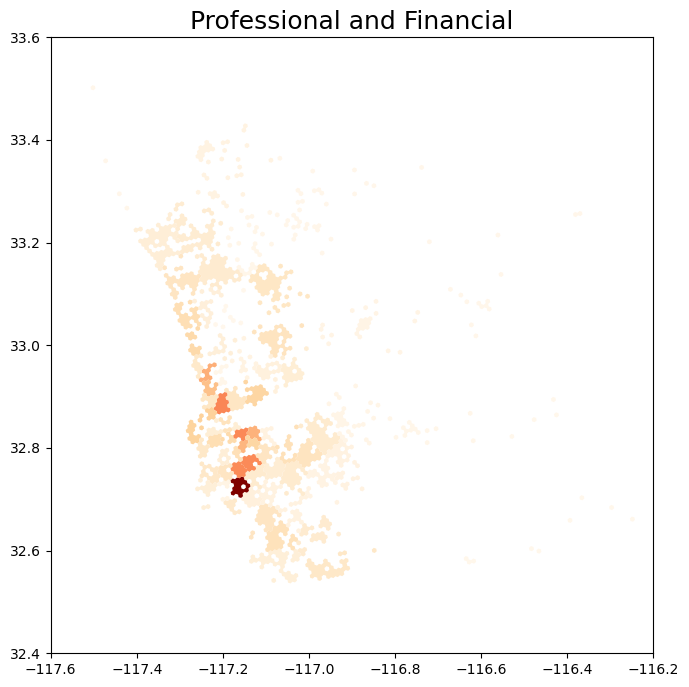

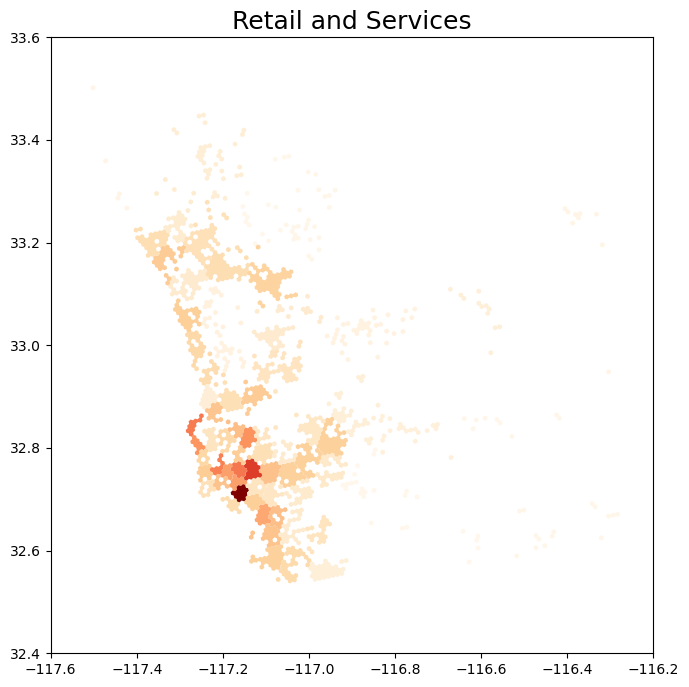

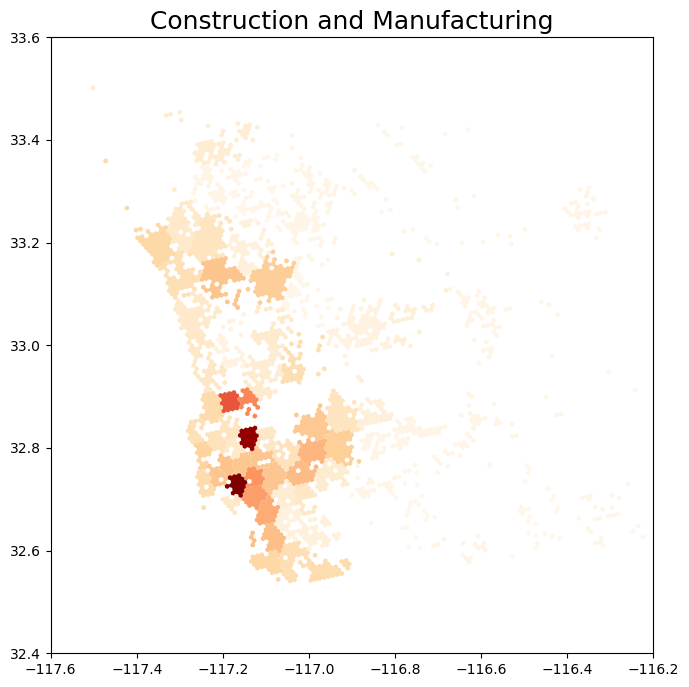

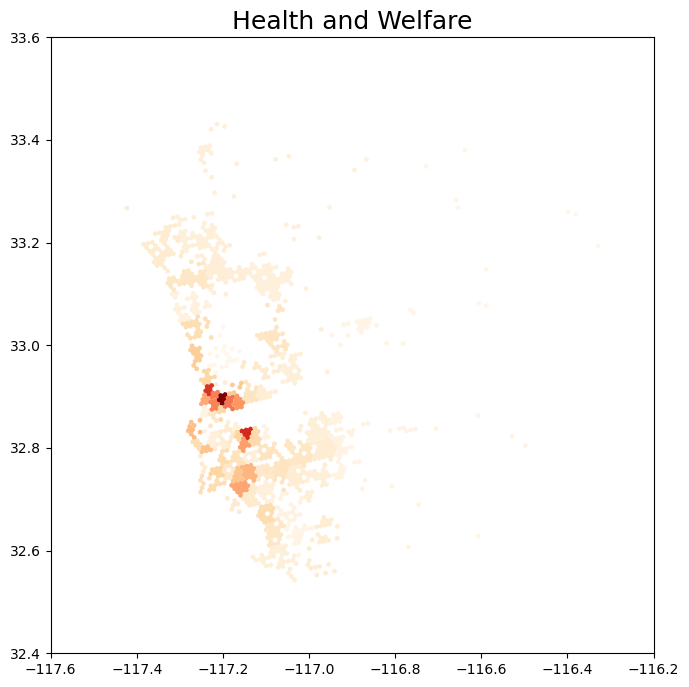

In [34]:
import warnings
warnings.filterwarnings('ignore')
for i in final_merge['Categories'].unique():
    df2 = final_merge[final_merge['Categories']==i].h3.geo_to_h3(10)
    df2['lng']=df2['x']
    df2['lat']=df2['y']
    df2['Count']=1
    df3 = df2[['lng','lat','Count']].reset_index().h3.geo_to_h3_aggregate(10, return_geometry=False).h3.h3_to_parent_aggregate(8)
    df3['x'] = df3['geometry'].centroid.x
    df3['y'] = df3['geometry'].centroid.y
    df = df3
    df['is_center'] = df['Count']>=df['Count'].sort_values(ascending=False).reset_index(drop=True)[70]
    cluster_centers = df[df['is_center']==True][['x', 'y']].values
    other_points = df[['x', 'y']].values
    k = len(cluster_centers)
    kmeans = KMeans(n_clusters=k, init=cluster_centers, n_init=1)
    kmeans.fit(other_points)
    df['cluster'] = kmeans.labels_
    # Plot clusters
    fig, ax = plt.subplots(figsize=(10, 8))
    df3 = df3.dissolve(by='cluster',aggfunc='sum')
    df3['area'] = df3['geometry'].area
    df3['business_density'] = df3['Count']/df3['area']
    export_merge = df3.set_geometry('geometry').sjoin(merged_blocks.set_geometry('centroid'), predicate='contains')
    export_merge = gpd.GeoDataFrame(export_merge.groupby(['geometry','business_density']).sum().reset_index()).set_geometry('geometry')
    

    export_merge.plot(ax=ax, column='business_density', legend=False, cmap='OrRd', markersize=5)
    export_merge.to_file('../output/'+i+'.json',driver="GeoJSON")
    ax.set_title(i, fontsize=18)
    ax.set_xlim([-117.6, -116.2])
    ax.set_ylim([32.4, 33.6])
    plt.show()

,geometry,business_density,Count,x,y,is_center,area,index_right,Total # of Jobs,Jobs for workers aged <=29,Jobs for workers aged 30-54,Jobs for workers aged 55+,Jobs with earnings >=$1250/month,Jobs with earnings $1251-$3333/month,Jobs with earnings $1333+/month
0,"MULTIPOLYGON (((-117.25069 32.70878, -117.2564...",88970.669841,5203,-85120.828049,23763.240686,121,0.058480,980742,3761,1040,1937,784,1068,1201,1492
1,"MULTIPOLYGON (((-117.24419 32.74907, -117.2499...",58961.131378,1102,-27201.356768,7602.033315,0,0.018690,506928,1664,663,769,232,464,650,550
2,"POLYGON ((-117.21662 32.74636, -117.22238 32.7...",117903.338875,6840,-84393.741342,23582.249809,90,0.058014,770102,12134,3047,6368,2719,2167,4351,5616
3,"POLYGON ((-117.23583 32.71414, -117.23703 32.7...",97525.833545,4180,-62359.237319,17410.771736,76,0.042860,680503,8213,1930,4505,1778,1235,2329,4649
4,"POLYGON ((-117.19937 32.74175, -117.19481 32.7...",69799.504257,5445,-113437.284585,31705.005351,0,0.078009,960465,12566,2723,6727,3116,1838,4105,6623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,"MULTIPOLYGON (((-116.92207 33.00366, -116.9208...",28275.932508,4368,-223331.532477,63130.620759,0,0.154478,732965,3316,742,1638,936,705,1348,1263
72,"MULTIPOLYGON (((-116.58935 33.08220, -116.5835...",22210.343571,180,-11655.683081,3322.940089,0,0.008104,73627,248,61,123,64,84,98,66
73,"MULTIPOLYGON (((-116.94033 32.80768, -116.9415...",36027.306379,8832,-354983.684609,99693.966542,0,0.245147,1105537,8749,1743,4770,2236,1582,2933,4234
74,"MULTIPOLYGON (((-116.94680 32.74398, -116.9479...",29492.976457,5300,-260257.072275,72942.512399,0,0.179704,833507,7101,1728,3761,1612,1806,2763,2532


In [24]:
df['Count'].sort_values(ascending=False).reset_index(drop=True)[72]

18

In [20]:
df3

,geometry,Count,x,y,is_center,area,business_density
cluster,,,,,,,
0,"MULTIPOLYGON (((-117.22400 32.79969, -117.2297...",27,-937.809549,262.560954,0,0.000645,41879.288257
1,"POLYGON ((-117.25374 32.78897, -117.25494 32.7...",62,-586.197935,163.986611,3,0.000403,153894.275150
2,"POLYGON ((-117.21944 32.80314, -117.22063 32.8...",35,-937.626161,262.469955,1,0.000645,54282.391694
3,"MULTIPOLYGON (((-117.26233 32.84726, -117.2611...",39,-351.793939,98.548302,1,0.000242,161334.432391
4,"MULTIPOLYGON (((-117.26091 32.81888, -117.2654...",83,-703.621297,196.988850,1,0.000483,171694.333269
...,...,...,...,...,...,...,...
71,"MULTIPOLYGON (((-117.08658 32.99169, -117.0877...",171,-3278.274403,924.609228,1,0.002260,75654.285436
72,"MULTIPOLYGON (((-117.22679 33.10364, -117.2325...",195,-5859.900753,1657.377628,0,0.004035,48325.716106
73,"MULTIPOLYGON (((-117.28974 33.18555, -117.2955...",176,-5393.761800,1527.751065,0,0.003712,47416.100494


<Axes: >

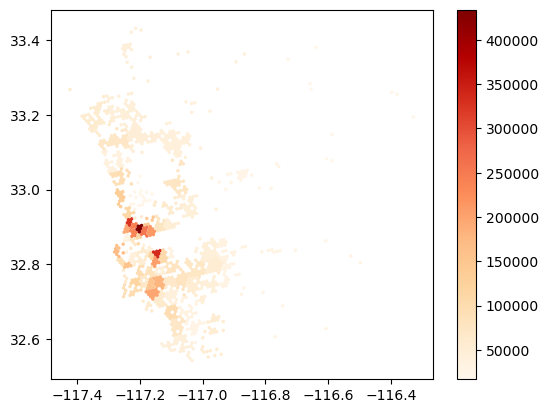

In [9]:
df3 = df3.dissolve(by='cluster',aggfunc='sum')
df3['area'] = df3['geometry'].area
df3['business_density'] = df3['Count']/df3['area']
df3.plot(column='business_density', legend=True,cmap='OrRd')

In [10]:
df3

,geometry,Count,x,y,is_center,area,business_density
cluster,,,,,,,
0,"MULTIPOLYGON (((-117.22975 32.80123, -117.2309...",27,-937.809549,262.560954,0,0.000645,41879.288257
1,"POLYGON ((-117.25374 32.78897, -117.25494 32.7...",62,-586.197935,163.986611,3,0.000403,153894.275150
2,"POLYGON ((-117.21944 32.80314, -117.22063 32.8...",35,-937.626161,262.469955,1,0.000645,54282.391694
3,"MULTIPOLYGON (((-117.26113 32.84228, -117.2656...",39,-351.793939,98.548302,1,0.000242,161334.432391
4,"MULTIPOLYGON (((-117.24843 32.83422, -117.2472...",83,-703.621297,196.988850,1,0.000483,171694.333269
...,...,...,...,...,...,...,...
71,"MULTIPOLYGON (((-117.09354 32.99822, -117.0947...",171,-3278.274403,924.609228,1,0.002260,75654.285436
72,"MULTIPOLYGON (((-117.19914 33.10096, -117.1945...",195,-5859.900753,1657.377628,0,0.004035,48325.716106
73,"MULTIPOLYGON (((-117.24813 33.16988, -117.2539...",176,-5393.761800,1527.751065,0,0.003712,47416.100494
